In [10]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import sys
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from healthrex_ml.evaluators import BinaryEvaluator
from tqdm import tqdm

In [11]:
from ngboost import NGBRegressor
from functions.trainers import NGBoostTrainer, LightGBMTrainer

In [12]:
trainer = NGBoostTrainer(working_dir="/deep/group/aihc/win23/EHR/20230207_baseline_jyx_mcp_withlast_artifacts")

In [13]:
tasks = ['label_NA', 'label_K', 'label_CR', 'label_CA', 'label_ALB']

In [14]:
# %%capture output
# for task in tasks:
#     trainer(task)

LightGBMError: Multiclass objective and metrics don't match

[LightGBM] [Fatal] Multiclass objective and metrics don't match


In [16]:
working_dir = "/deep/group/aihc/win23/EHR/20230207_baseline_jyx_mcp_withlast_artifacts"
y_hats_NA = pd.read_csv(
            os.path.join(working_dir, 'label_NA_yhats.csv'))
y_hats_K = pd.read_csv(
            os.path.join(working_dir, 'label_K_yhats.csv'))
y_hats_CR = pd.read_csv(
            os.path.join(working_dir, 'label_CR_yhats.csv'))
y_hats_CA = pd.read_csv(
            os.path.join(working_dir, 'label_CA_yhats.csv'))
y_hats_ALB = pd.read_csv(
            os.path.join(working_dir, 'label_ALB_yhats.csv'))

In [17]:
y_test = pd.read_csv(
    os.path.join(working_dir, "test_labels.csv"))

In [19]:
d_NA = 0.1 * y_test["label_last_NA"]
d_K = 0.1 * y_test["label_last_K"]
d_CR = 0.1 * y_test["label_last_CR"]
d_CA = 0.1 * y_test["label_last_CA"]
d_ALB = 0.1 * y_test["label_last_ALB"]

In [20]:
y_hats_NA["upper_z"] = (y_test["label_last_NA"] + d_NA - y_hats_NA["dist_mean"]) / np.sqrt(y_hats_NA["dist_var"])
y_hats_NA["lower_z"] = (y_test["label_last_NA"] - d_NA - y_hats_NA["dist_mean"]) / np.sqrt(y_hats_NA["dist_var"])
y_hats_NA["upper_p"] = 1 - norm.cdf(y_hats_NA["upper_z"])
y_hats_NA["lower_p"] = norm.cdf(y_hats_NA["lower_z"])
y_hats_NA["stable_p"] = 1 - y_hats_NA["upper_p"] - y_hats_NA["lower_p"]

In [21]:
y_hats_K["upper_z"] = (y_test["label_last_K"] + d_K - y_hats_K["dist_mean"]) / np.sqrt(y_hats_K["dist_var"])
y_hats_K["lower_z"] = (y_test["label_last_K"] - d_K - y_hats_K["dist_mean"]) / np.sqrt(y_hats_K["dist_var"])
y_hats_K["upper_p"] = 1 - norm.cdf(y_hats_K["upper_z"])
y_hats_K["lower_p"] = norm.cdf(y_hats_K["lower_z"])
y_hats_K["stable_p"] = 1 - y_hats_K["upper_p"] - y_hats_K["lower_p"]

In [22]:
y_hats_CR["upper_z"] = (y_test["label_last_CR"] + d_CR - y_hats_CR["dist_mean"]) / np.sqrt(y_hats_CR["dist_var"])
y_hats_CR["lower_z"] = (y_test["label_last_CR"] - d_CR - y_hats_CR["dist_mean"]) / np.sqrt(y_hats_CR["dist_var"])
y_hats_CR["upper_p"] = 1 - norm.cdf(y_hats_CR["upper_z"])
y_hats_CR["lower_p"] = norm.cdf(y_hats_CR["lower_z"])
y_hats_CR["stable_p"] = 1 - y_hats_CR["upper_p"] - y_hats_CR["lower_p"]

In [23]:
y_hats_CA["upper_z"] = (y_test["label_last_CA"] + d_CA - y_hats_CA["dist_mean"]) / np.sqrt(y_hats_CA["dist_var"])
y_hats_CA["lower_z"] = (y_test["label_last_CA"] - d_CA - y_hats_CA["dist_mean"]) / np.sqrt(y_hats_CA["dist_var"])
y_hats_CA["upper_p"] = 1 - norm.cdf(y_hats_CA["upper_z"])
y_hats_CA["lower_p"] = norm.cdf(y_hats_CA["lower_z"])
y_hats_CA["stable_p"] = 1 - y_hats_CA["upper_p"] - y_hats_CA["lower_p"]

In [24]:
y_hats_ALB["upper_z"] = (y_test["label_last_ALB"] + d_ALB - y_hats_ALB["dist_mean"]) / np.sqrt(y_hats_ALB["dist_var"])
y_hats_ALB["lower_z"] = (y_test["label_last_ALB"] - d_ALB - y_hats_ALB["dist_mean"]) / np.sqrt(y_hats_ALB["dist_var"])
y_hats_ALB["upper_p"] = 1 - norm.cdf(y_hats_ALB["upper_z"])
y_hats_ALB["lower_p"] = norm.cdf(y_hats_ALB["lower_z"])
y_hats_ALB["stable_p"] = 1 - y_hats_ALB["upper_p"] - y_hats_ALB["lower_p"]

In [25]:
y_test["label_NA_stable"] = (y_test["label_last_NA"] - d_NA < y_test["label_NA"]) & (y_test["label_NA"] < y_test["label_last_NA"] + d_NA)
y_test["label_K_stable"] = (y_test["label_last_K"] - d_K < y_test["label_K"]) & (y_test["label_K"] < y_test["label_last_K"] + d_K)
y_test["label_CR_stable"] = (y_test["label_last_CR"] - d_CR < y_test["label_CR"]) & (y_test["label_CR"] < y_test["label_last_CR"] + d_CR)
y_test["label_CA_stable"] = (y_test["label_last_CA"] - d_CA < y_test["label_CA"]) & (y_test["label_CA"] < y_test["label_last_CA"] + d_CA)
y_test["label_ALB_stable"] = (y_test["label_last_ALB"] - d_ALB < y_test["label_ALB"]) & (y_test["label_ALB"] < y_test["label_last_ALB"] + d_ALB)

In [26]:
y_test["label_NA_lower"] = (y_test["label_last_NA"] - d_NA > y_test["label_NA"])
y_test["label_K_lower"] = (y_test["label_last_K"] - d_K > y_test["label_K"])
y_test["label_CR_lower"] = (y_test["label_last_CR"] - d_CR > y_test["label_CR"])
y_test["label_CA_lower"] = (y_test["label_last_CA"] - d_CA > y_test["label_CA"])
y_test["label_ALB_lower"] = (y_test["label_last_ALB"] - d_ALB > y_test["label_ALB"])

In [27]:
y_test["label_NA_higher"] = (y_test["label_NA"] > y_test["label_last_NA"] + d_NA)
y_test["label_K_higher"] = (y_test["label_K"] > y_test["label_last_K"] + d_K)
y_test["label_CR_higher"] = (y_test["label_CR"] > y_test["label_last_CR"] + d_CR)
y_test["label_CA_higher"] = (y_test["label_CA"] > y_test["label_last_CA"] + d_CA)
y_test["label_ALB_higher"] = (y_test["label_ALB"] > y_test["label_last_ALB"] + d_ALB)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:04<00:00, 25.00s/it]


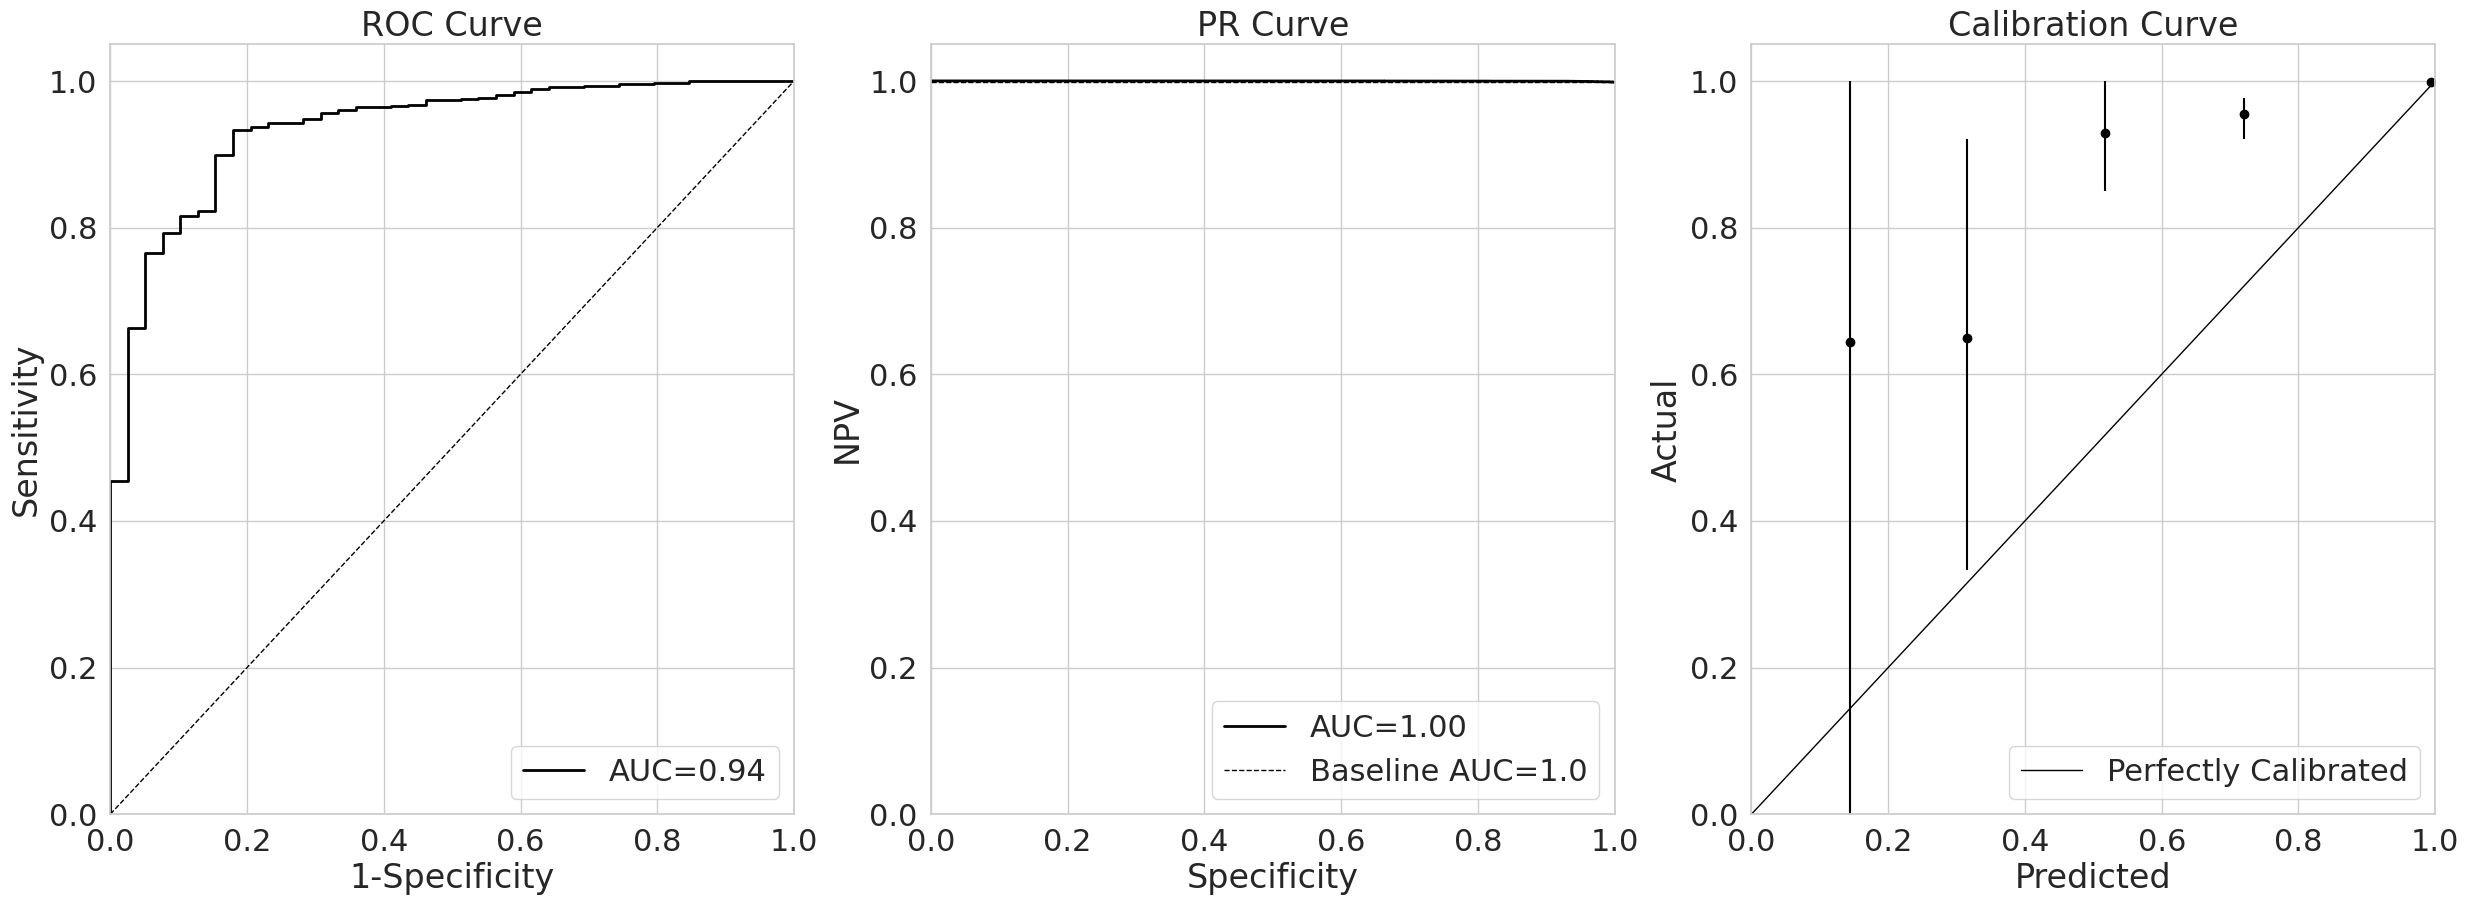

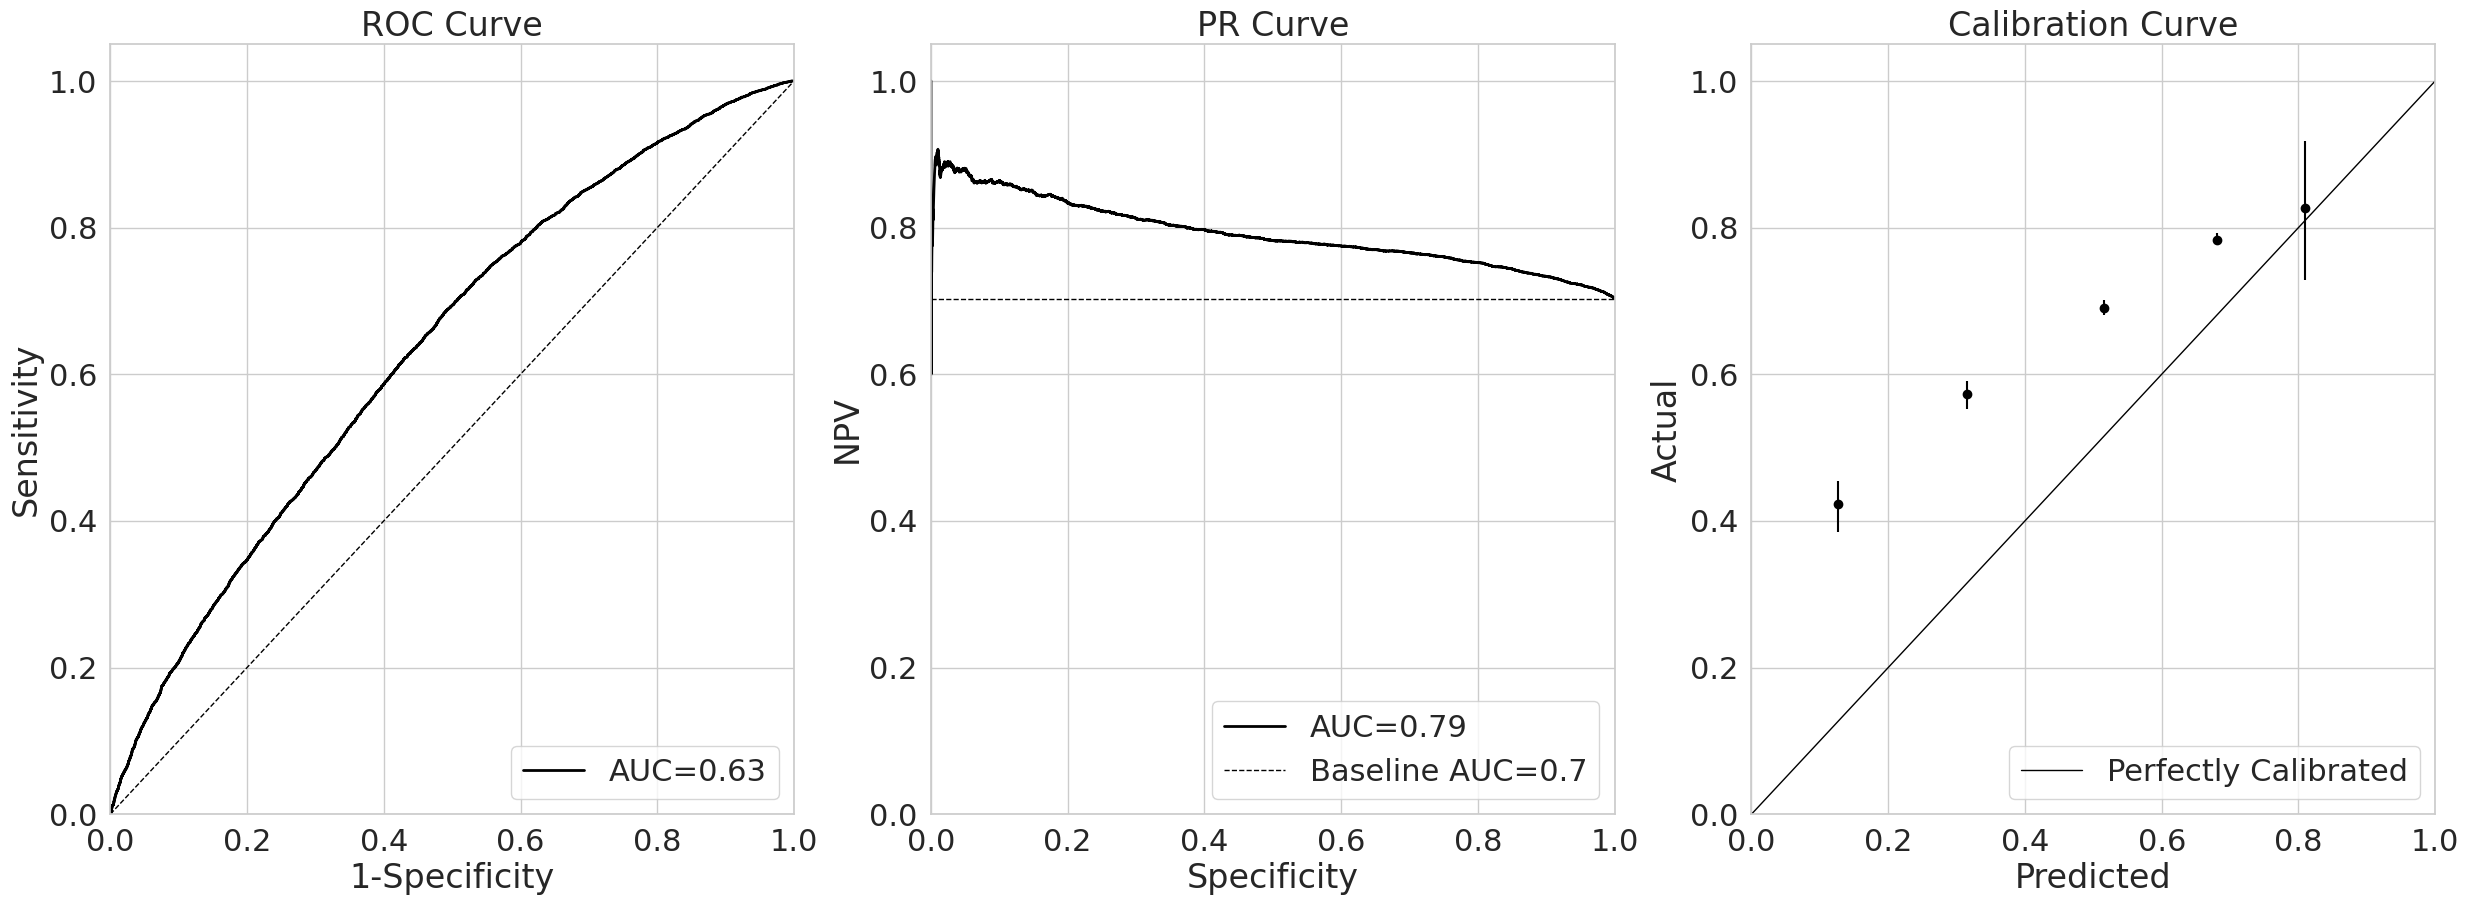

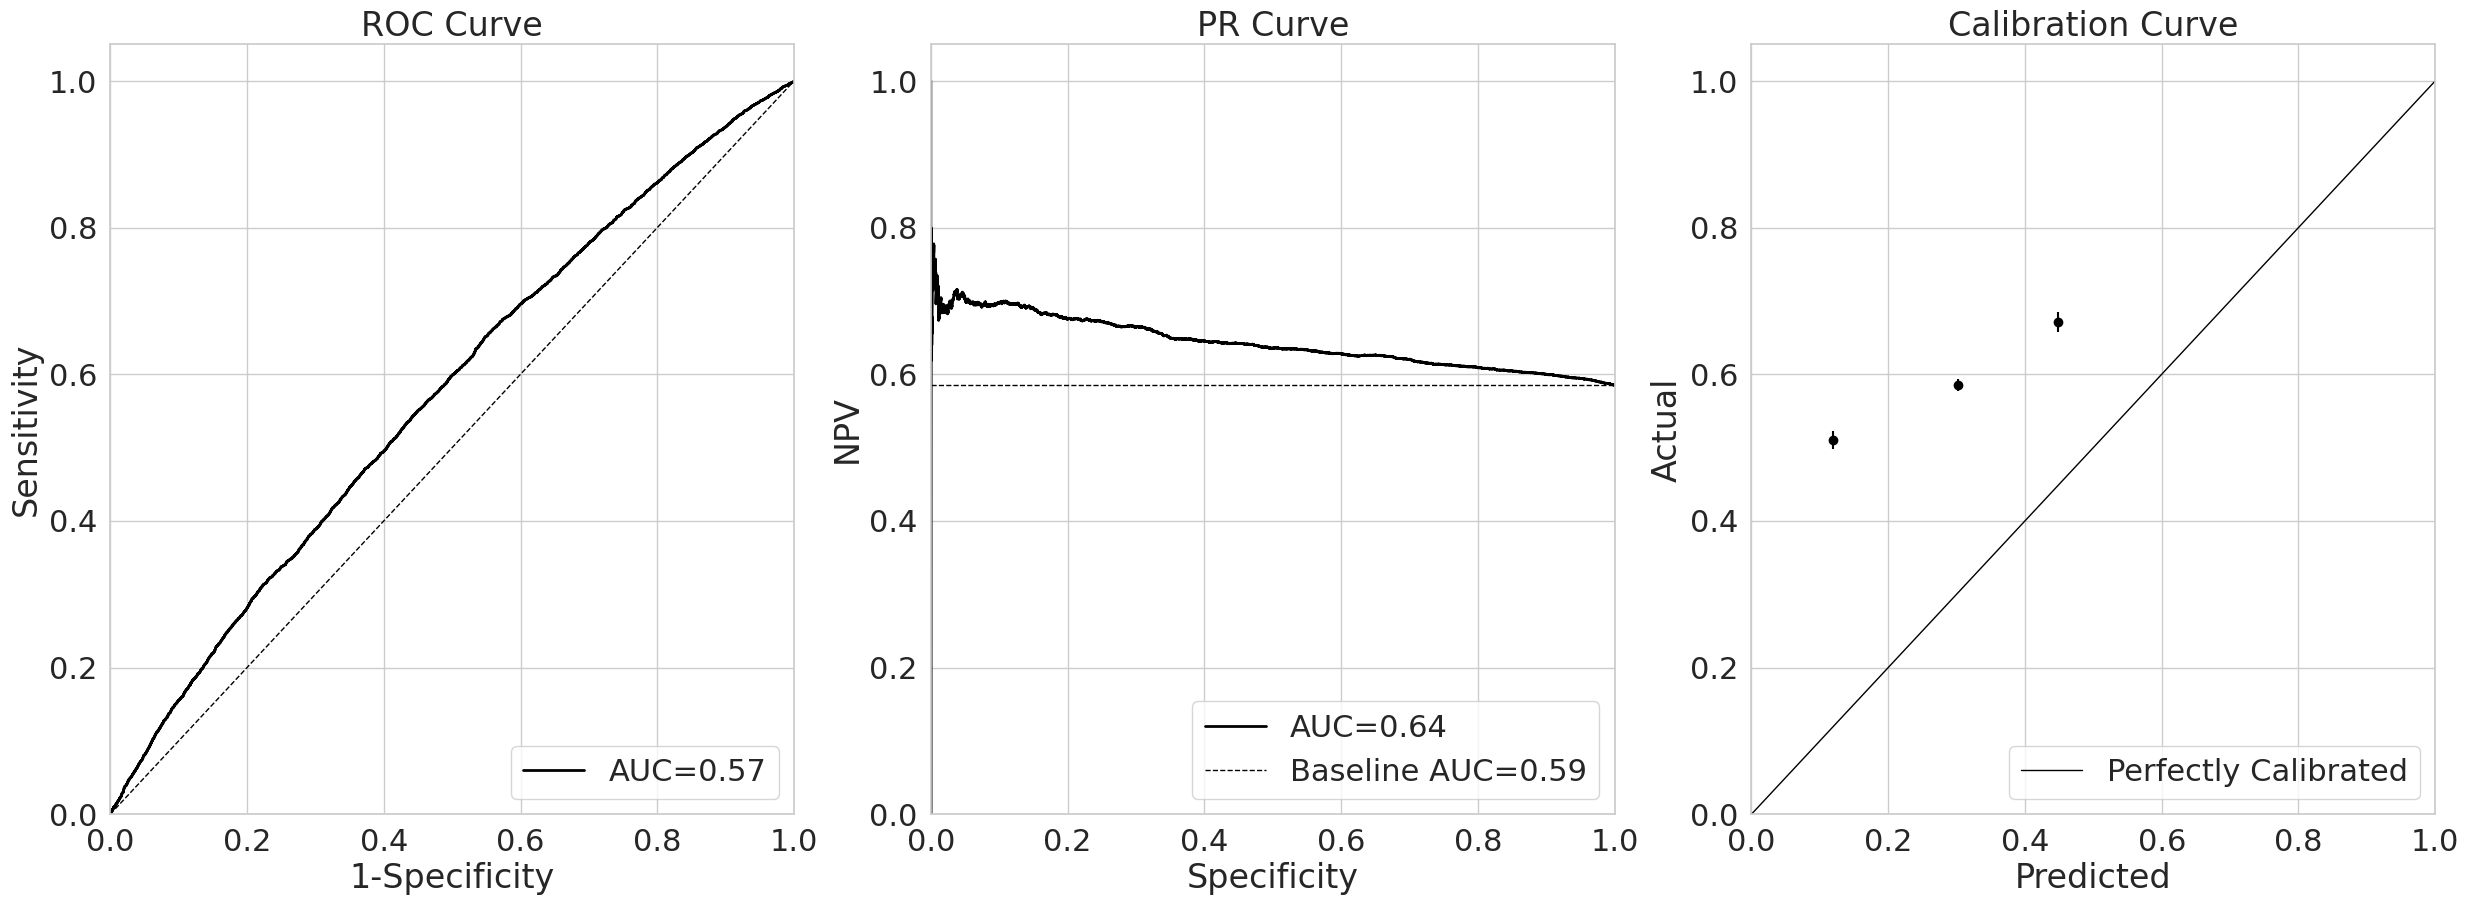

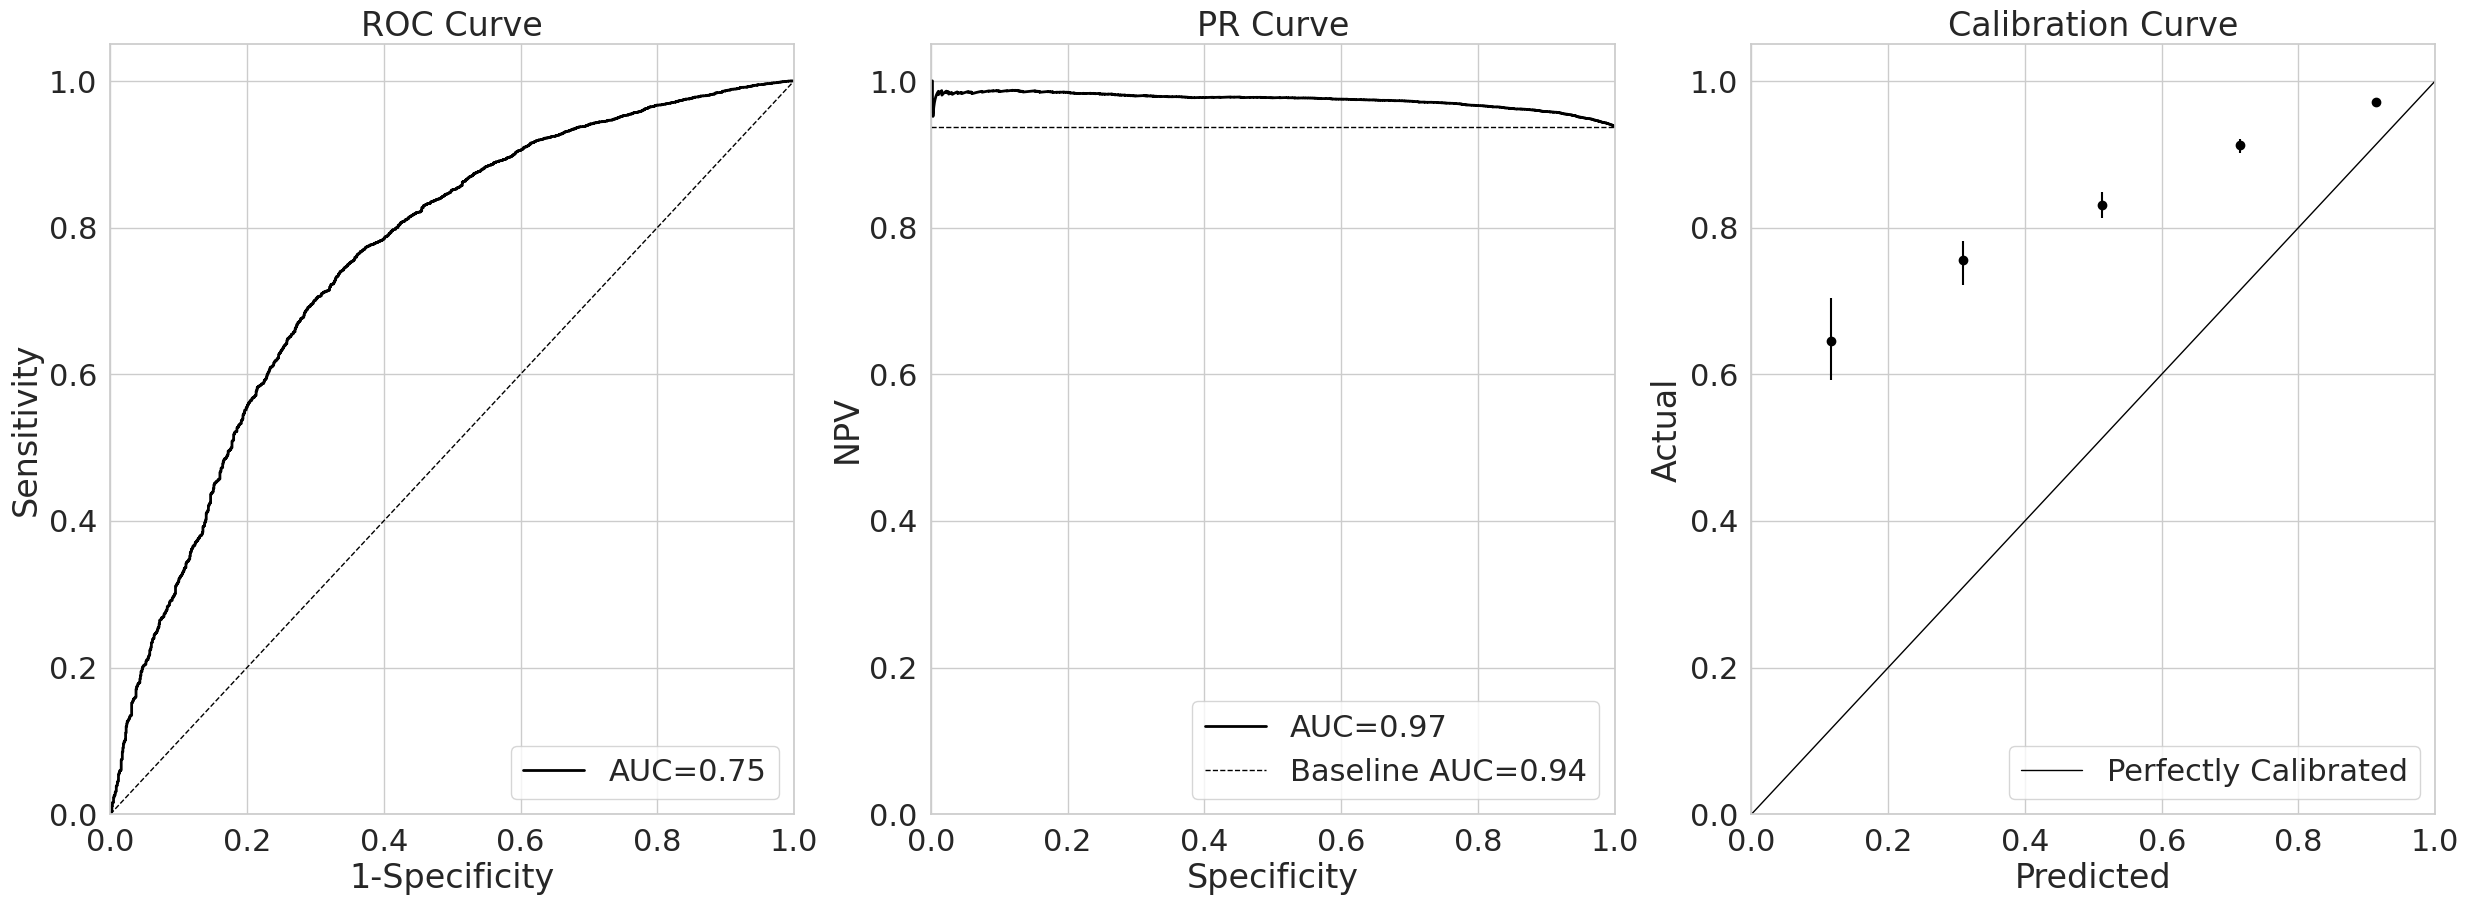

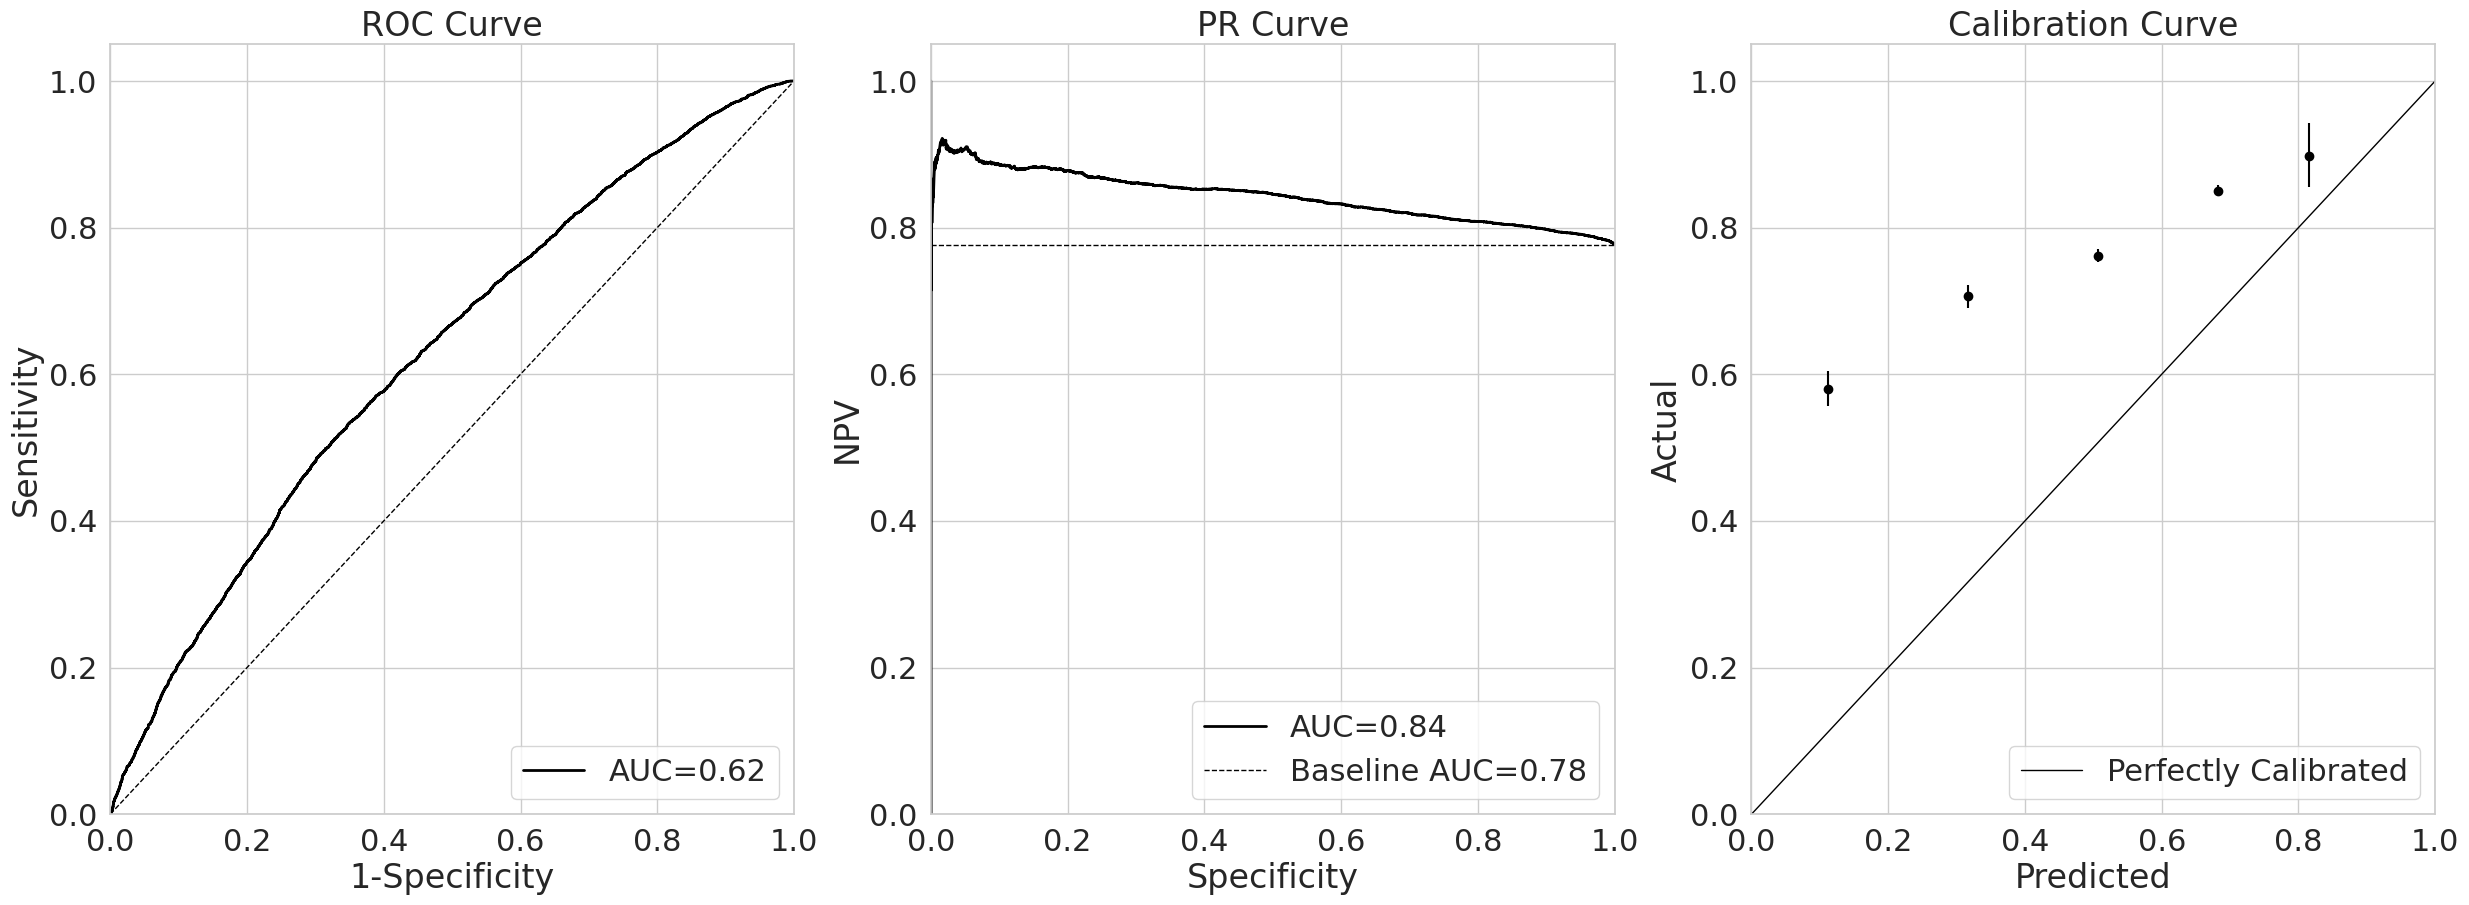

In [162]:
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir="/deep/group/aihc/win23/EHR/20230207_baseline_jyx_mcp_withlast_artifacts",
        task_name=task
    )
    key = task + "_stable"
    pred = None
    if task == "label_NA":
        pred = y_hats_NA["stable_p"]
    elif task == "label_K":
        pred = y_hats_K["stable_p"]
    elif task == "label_CR":
        pred = y_hats_CR["stable_p"]
    elif task == "label_CA":
        pred = y_hats_CA["stable_p"]
    elif task == "label_ALB":
        pred = y_hats_ALB["stable_p"]
    evalr(y_test[key], pred)

In [163]:
y_test

,anon_id,observation_id,index_time,ordering_mode,label_NA,label_K,label_CR,label_CA,label_ALB,label_last_NA,...,label_NA_lower,label_K_lower,label_CR_lower,label_CA_lower,label_ALB_lower,label_NA_higher,label_K_higher,label_CR_higher,label_CA_higher,label_ALB_higher
0,JC3045286,694873001.0,2021-01-01 06:01:00+00:00,Inpatient,137.0,4.1,0.50,9.0,3.1,138.0,...,False,False,True,False,False,False,False,False,False,False
1,JC1789173,694873235.0,2021-01-01 06:01:00+00:00,Inpatient,146.0,3.6,0.60,8.8,3.6,138.0,...,False,False,True,False,False,False,False,False,False,False
2,JC2663298,695304535.0,2021-01-03 02:52:00+00:00,Outpatient,143.0,3.9,0.51,8.3,3.1,141.0,...,False,False,False,False,True,False,False,False,False,False
3,JC2179601,695444770.0,2021-01-03 20:27:00+00:00,Inpatient,140.0,3.6,0.46,8.4,2.6,141.0,...,False,False,False,False,False,False,False,False,False,False
4,JC2075884,695531076.0,2021-01-03 03:31:00+00:00,Inpatient,139.0,4.4,1.03,9.0,4.2,139.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,JC2444614,757020436.0,2021-09-30 07:00:00+00:00,Outpatient,140.0,3.9,0.26,9.0,3.3,140.0,...,False,False,False,False,False,False,True,True,False,False
19996,JC1932135,757073858.0,2021-09-30 05:00:00+00:00,Inpatient,132.0,3.8,0.65,8.2,2.8,135.0,...,False,False,True,False,False,False,False,False,False,False
19997,JC3071871,757108530.0,2021-09-30 07:00:00+00:00,Inpatient,136.0,3.9,0.77,9.8,4.4,135.0,...,False,False,False,False,False,False,False,False,False,False
19998,JC1666662,757122914.0,2021-09-30 07:00:00+00:00,Inpatient,139.0,3.9,0.95,9.6,4.4,137.0,...,False,True,False,False,False,False,False,True,False,False


In [31]:
m = y_hats_K.loc[1]["dist_mean"]
sig = np.sqrt(y_hats_K.loc[1]["dist_var"])
lower = y_test.loc[1]["label_last_K"] * 0.9
higher = y_test.loc[1]["label_last_K"] * 1.1

In [37]:
y_test_K = y_test[["anon_id","observation_id", "index_time","label_K", "label_last_K", "label_K_lower", "label_K_higher"]]

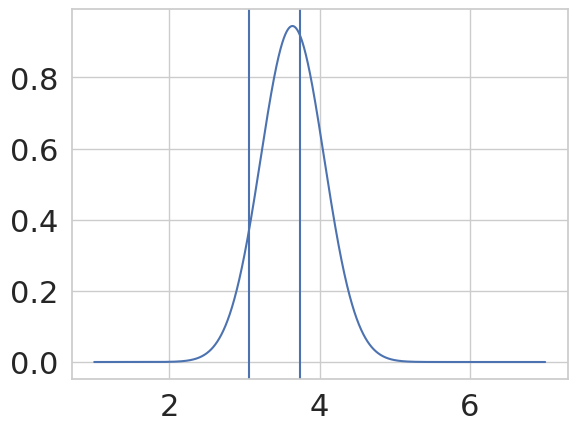

In [43]:
x_axis = np.arange(1,7, 0.0001)
plt.plot(x_axis, norm.pdf(x_axis, m, sig))
plt.axvline(x = lower)
plt.axvline(x = higher)